# Text Classification


In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
from transformers import DistilBertTokenizer, AutoModel
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

#### A First Look at Hugging Face Datasets
link: https://github.com/huggingface/datasets

In [2]:
# load the emotion dataset with the load_dataset() function:
emotions = load_dataset("emotion")
emotions

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/andsfonseca/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
# we can use the usual dictionary syntax to access an individual split:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [4]:
print("Length: ", len(train_ds))
print("Column names:", train_ds.column_names)
print("Values: ", train_ds.features)
print("Access a single example by its index:", train_ds[0])

Length:  16000
Column names: ['text', 'label']
Values:  {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
Access a single example by its index: {'text': 'i didnt feel humiliated', 'label': 0}


#### From Datasets to DataFrames


In [5]:
emotions.set_format(type="pandas")

In [6]:
df_train = emotions["train"][:]

df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df_train["label_name"] = df_train["label"].apply(label_int2str)

df_train.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


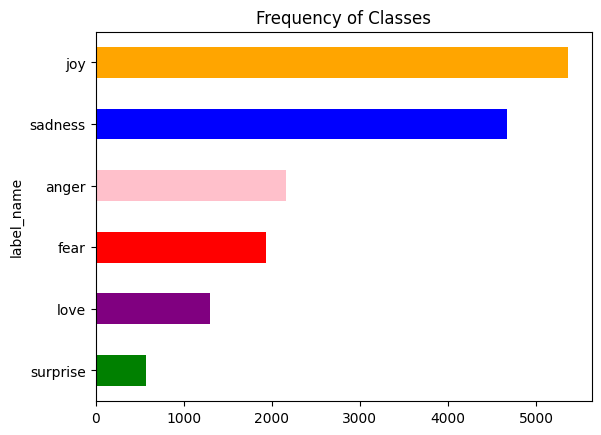

In [8]:
df_train["label_name"].value_counts(ascending=True).plot.barh(color={"red", "green", "pink", "blue", "orange", "purple"})
plt.title("Frequency of Classes")
plt.show()

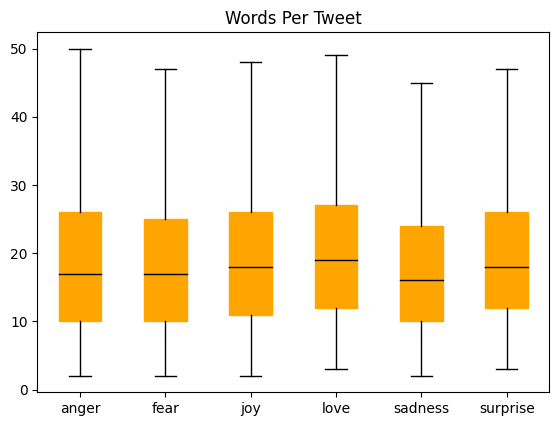

In [9]:
df_train["Words Per Tweet"] = df_train["text"].str.split().apply(len)

props = dict(boxes="Orange", whiskers="Black", medians="Black", caps="Black")
boxplot = df_train.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color=props, patch_artist=True)

plt.suptitle("")
plt.xlabel("")
plt.show()

In [10]:
emotions.reset_format()

### From Text to Tokens


#### Character Tokenization

In [11]:
example_text = df_train["text"][31]
example_text

'i remember feeling acutely distressed for a few days'

In [12]:
tokenized_example_text = list(example_text)
print(tokenized_example_text)

['i', ' ', 'r', 'e', 'm', 'e', 'm', 'b', 'e', 'r', ' ', 'f', 'e', 'e', 'l', 'i', 'n', 'g', ' ', 'a', 'c', 'u', 't', 'e', 'l', 'y', ' ', 'd', 'i', 's', 't', 'r', 'e', 's', 's', 'e', 'd', ' ', 'f', 'o', 'r', ' ', 'a', ' ', 'f', 'e', 'w', ' ', 'd', 'a', 'y', 's']


In [13]:
token2id_example = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_example_text)))}
print(token2id_example)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'i': 8, 'l': 9, 'm': 10, 'n': 11, 'o': 12, 'r': 13, 's': 14, 't': 15, 'u': 16, 'w': 17, 'y': 18}


In [14]:
tokenized_example_ids = [token2id_example[token] for token in tokenized_example_text]
print(tokenized_example_ids)

[8, 0, 13, 5, 10, 5, 10, 2, 5, 13, 0, 6, 5, 5, 9, 8, 11, 7, 0, 1, 3, 16, 15, 5, 9, 18, 0, 4, 8, 14, 15, 13, 5, 14, 14, 5, 4, 0, 6, 12, 13, 0, 1, 0, 6, 5, 17, 0, 4, 1, 18, 14]


<hr style="height:2px;border:none;background-color:gray;"></hr>

##### One-hot vectors

Each token has now been mapped to a unique numerical identifier (hence the name input_ids). The last step is to convert input_ids to a 2D tensor of one-hot vectors. You can see a example in this notebook [One-hot Vectors](./2-text-classification/one_hot_vector.ipynb)

<hr style="height:2px;border:none;background-color:gray;"></hr>

In [15]:
input_ids = torch.tensor(tokenized_example_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2id_example))
one_hot_encodings.shape

torch.Size([52, 19])

In [16]:
print(f"Token: {tokenized_example_text[0]}")
print(f"Tensor index: {tokenized_example_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: i
Tensor index: 8
One-hot: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


#### Word Tokenization

In [17]:
tokenized_word_example_text = example_text.split()
tokenized_word_example_text

['i',
 'remember',
 'feeling',
 'acutely',
 'distressed',
 'for',
 'a',
 'few',
 'days']

In [18]:
token2id_word_example = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_word_example_text)))}
print(token2id_word_example)

{'a': 0, 'acutely': 1, 'days': 2, 'distressed': 3, 'feeling': 4, 'few': 5, 'for': 6, 'i': 7, 'remember': 8}


In [19]:
tokenized_word_example_ids = [token2id_word_example[token] for token in tokenized_word_example_text]
print(tokenized_word_example_ids)

[7, 8, 4, 1, 3, 6, 0, 5, 2]


In [20]:
input_ids = torch.tensor(tokenized_word_example_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2id_word_example))
print(f"Token: {tokenized_word_example_text[2]}")
print(f"Tensor index: {tokenized_word_example_ids[2]}")
print(f"One-hot: {one_hot_encodings[2]}")

Token: feeling
Tensor index: 4
One-hot: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0])


#### Subword Tokenization

In [21]:
model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [22]:
# gerando os tokens usando Distilbert Tokenizer
encoded_text = distilbert_tokenizer(example_text)

print(example_text)
print(encoded_text["input_ids"])

i remember feeling acutely distressed for a few days
[101, 1045, 3342, 3110, 11325, 2135, 24305, 2005, 1037, 2261, 2420, 102]


In [23]:
# vendo os tokens
tokens = distilbert_tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'i',
 'remember',
 'feeling',
 'acute',
 '##ly',
 'distressed',
 'for',
 'a',
 'few',
 'days',
 '[SEP]']

In [24]:
# convertendo os tokens para texto
distilbert_tokenizer.convert_tokens_to_string(tokens)

'[CLS] i remember feeling acutely distressed for a few days [SEP]'

In [25]:
# tamanho do vocabulário
distilbert_tokenizer.vocab_size

30522

In [26]:
# tamanho máximo do contexto
distilbert_tokenizer.model_max_length

512

In [27]:
# nomes dos campos que o modelo espera
distilbert_tokenizer.model_input_names

['input_ids', 'attention_mask']

### Tokenizing the Whole Dataset

In [28]:
def tokenize(batch):
    return distilbert_tokenizer(batch["text"], padding=True, truncation=True)

In [29]:
print(tokenize(emotions["train"][:2])["input_ids"])

[[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]]


|   Special Token  | [PAD] | [UNK] | [CLS] | [SEP] | [MASK] |
|:----------------:|:-----:|:-----:|:-----:|:-----:|:------:|
| Special Token ID |   0   |  100  |  101  |  102  |   103  |

In [30]:
tokens = distilbert_tokenizer.convert_ids_to_tokens(tokenize(emotions["train"][:2])["input_ids"][0])
tokens

['[CLS]',
 'i',
 'didn',
 '##t',
 'feel',
 'humiliated',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [31]:
# aplicando em todo o dataset a função tokenizadora
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-fc5b5c6c07369ad1.arrow
Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-177bbc180abd22e9.arrow
Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-42c6f6b0ef07b3a9.arrow


In [32]:
for i in range(1):
    row = emotions_encoded["train"][i]  
    print(row["text"]) 
    print(row["input_ids"]) 


i didnt feel humiliated
[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Training a Text Classifier

* Feature Extraction
* Fine-tuning

### Transformers as Feature Extractor

#### Using pretrained models

In [33]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Extracting the last hidden states

In [34]:
example_text

'i remember feeling acutely distressed for a few days'

In [35]:

inputs = distilbert_tokenizer(example_text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 12])


In [36]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
 outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[ 0.0267,  0.0243, -0.1351,  ...,  0.0231,  0.1226,  0.2348],
         [ 0.3981,  0.1839, -0.3101,  ...,  0.1541,  0.6333,  0.0120],
         [-0.0371,  0.1825, -0.0489,  ...,  0.0914, -0.3788, -0.2676],
         ...,
         [-0.2624, -0.3020,  0.2109,  ..., -0.3921, -0.6568, -0.0390],
         [-0.2264, -0.1025, -0.0399,  ..., -0.1844, -0.3466, -0.4665],
         [ 0.9699,  0.1726, -0.3798,  ...,  0.2346, -0.4845, -0.4161]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [37]:
outputs.last_hidden_state.size()

torch.Size([1, 12, 768])

In [38]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [39]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in distilbert_tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [40]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [41]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=512)

Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-3697ead2643d07bf.arrow
Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-ba293d16c35cf5f3.arrow
Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-14c96dd14177ecf4.arrow


In [42]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

#### Creating a feature matrix

In [43]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### Visualizing the training set

In [44]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.555764,6.807881,0
1,-2.872635,6.452621,0
2,5.585249,3.353567,3
3,-2.266281,4.277770,2
4,-3.331518,4.543366,3


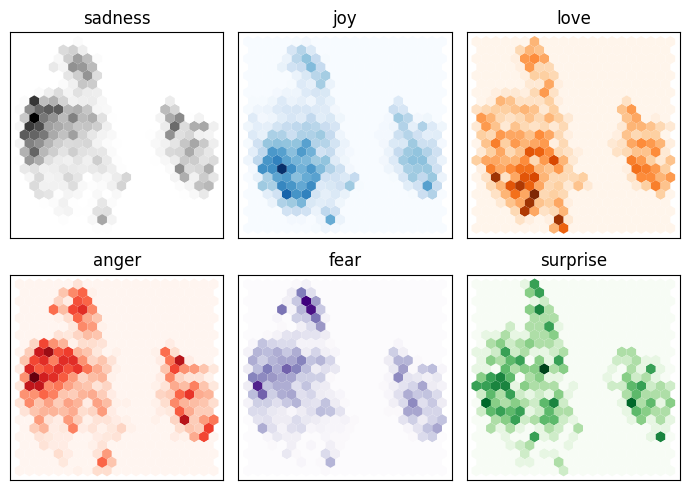

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
    gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

#### Training a simple classifier

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [48]:
from sklearn.dummy import DummyClassifier

In [49]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

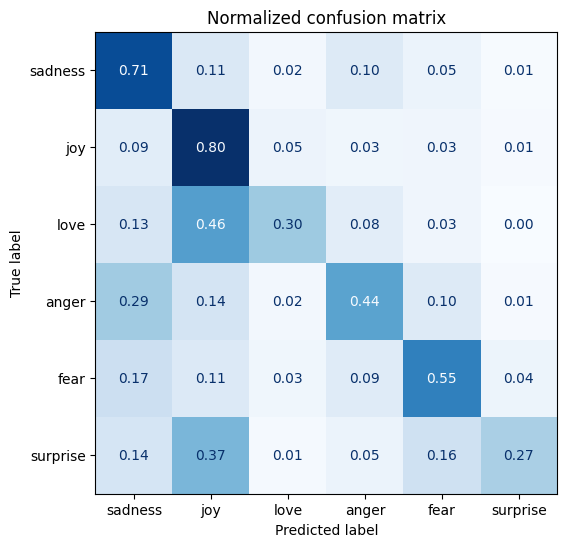

In [51]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-Tuning Transformers

#### Loading a pretrained model

In [52]:
from transformers import AutoModelForSequenceClassification


In [53]:
num_labels = 6
model = (AutoModelForSequenceClassification
 .from_pretrained(model_ckpt, num_labels=num_labels)
 .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

#### Defining the performance metric

In [54]:
from sklearn.metrics import accuracy_score, f1_score

In [56]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### Training the model

In [57]:
from transformers import Trainer, TrainingArguments

In [64]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
output_dir = f"models/{model_name}"
training_args = TrainingArguments(output_dir=output_dir,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [65]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=distilbert_tokenizer)
trainer.train()

d:\Documents\Workspaces\Python\nlp-with-transformers\.venv\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [ ]:
preds_output.metrics

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)